**请填写你的姓名与学号**

In [92]:
name="朱永山"
student_id="23009200687"

# 逻辑回归模型编程练习

In [93]:
# 查看当前挂载的数据集目录
!ls
#!find . -type f -name LR_data1.txt
#!find . -type f -name LR_data2.txt

LR_data1.txt              LR_data2_boundary.png     logistic-regression.ipynb
LR_data1_visual.png       LR_data2_visual.png
LR_data2.txt              environment.yml


本次作业的目的是建立一个逻辑回归模型，用于预测一个学生是否应该被大学录取。

简单起见，大学通过**两次考试的成绩来确定一个学生是否应该录取**。你有以前数届考生的成绩，可以做为训练集学习逻辑回归模型。每个训练样本包括了考生两次考试的成绩和对应的录取决定。

你的任务是建立一个分类模型，根据两次考试的成绩来估计考生被录取的概率。
本次实验需要实现的函数
- `plot_data` 绘制二维的分类数据。
- `sigmoid`函数
- `cost_function` 逻辑回归的代价函数
- `cost_gradient` 逻辑回归的代价函数的梯度，无正则化
- `predict` 逻辑回归的预测函数
- `cost_function_reg` 逻辑回归带正则化项的代价函数
- `cost_gradient_reg` 逻辑回归的代价函数的梯度，带正则化

In [94]:
# 导入需要用到的库
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt

## 数据可视化
在实现机器学习算法前，可视化的显示数据以观察其规律通常是有益的。本次作业中，你需要实现 `plot_data` 函数，用于绘制所给数据的散点图。你绘制的图像应如下图所示，两坐标轴分别为两次考试的成绩，正负样本分别使用不同的标记显示。

In [95]:
def plot_data(X, y):
    """This function plots the data points X and y into a new figure.
    It plots the data points with red + for the positive examples,
    and blue o the negative examples. X is assumed to be a Mx2 matrix.
    
    X: shape:nx2 
    y: shape:nx1
    """

    plt.figure()
    # ====================== YOUR CODE HERE ======================
    admitted_index = []
    for i in range(y.size):
        if y[i] == 1:
            admitted_index.append(i)

    not_admitted_index = [i for i in range(y.size) if i not in admitted_index]

    plt.scatter(X[admitted_index, 0], X[admitted_index, 1], color='red', marker='+', label='Admitted')
    plt.scatter(X[not_admitted_index, 0], X[not_admitted_index, 1], color='darkblue', marker='o', label='Not admitted')
    # ============================================================

    plt.xlabel("Exam 1 Score")
    plt.ylabel("Exam 2 Score")
    plt.legend(loc='upper right')

调用 `plot_data`，可视化第一个文件`LR_data1`数据。绘制的图像如下：‘

![data1](LR_data1_visual.png)

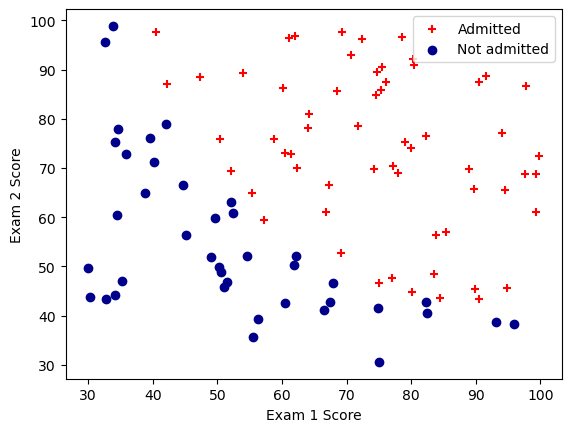

In [96]:
# 加载数据 注意使用 !ls 或 !find 命令确定数据文件所在的目录 dataXXXX 。
data = np.loadtxt("LR_data1.txt", delimiter=",")
X, y = data[:, :2], data[:, 2]

# 可视化数据
# ====================== YOUR CODE HERE ================
y = y.reshape(100,1)
plot_data(X, y)
# ======================================================
plt.show()

绘制分类面

In [97]:
def plot_decision_boundary(theta, X, y):
    """绘制分类面。"""
    plot_data(X[:, 1:], y)

    _, d = X.shape

    if d <= 3:
        plot_x = np.array([np.min(X[:, 1])-2, np.max(X[:, 1])+2])
        plot_y = -1.0 / theta[2]*(theta[1]*plot_x + theta[0])
        plt.plot(plot_x, plot_y, 'm-', label="Decision Boundary")

        plt.xlim([30, 100])
        plt.ylim([30, 100])
    else:
        n_grid = 50
        u = np.linspace(-1, 1.5, n_grid)
        v = np.linspace(-1, 1.5, n_grid)

        z = np.zeros((n_grid, n_grid))

        for i in range(n_grid):
            for j in range(n_grid):
                uu, vv = np.array([u[i]]), np.array([v[j]])
                z[i, j] = np.dot(map_feature(uu, vv), theta)

        z = z.T

        CS = plt.contour(u, v, z, linewidths=2, levels=[0.0], colors=['m'])
        CS.collections[0].set_label('Decision boundary')

    plt.legend()

## 热身练习：Sigmoid函数

逻辑回归的假设模型为：
$$h_{\theta}(x) = g(\theta^{\mathrm{T}} x)$$	

其中函数 $g(\cdot)$ 是Sigmoid函数，定义为：
$$g(z) = \frac{1}{1+\exp(-z)}$$

本练习中第一步需要你实现 Sigmoid 函数。在实现该函数后，你需要确认其功能正确。对于输入为矩阵和向量的情况，你实现的函数应当对每一个元素执行Sigmoid 函数。

In [116]:
def sigmoid(z):
    """Compute sigmoid function"""

    z = np.asarray(z)
    g = np.zeros_like(z)

    # ====================== YOUR CODE HERE ======================
    g = 1 / (1 + np.exp(-z))
    # ============================================================

    return g

In [117]:
# 测试 sigmoid 函数
z = np.array([-10.0, -5.0, 0.0, 5.0, 10.0])
g = sigmoid(z)
print("Value of sigmoid at [-10, -5, 0, 5, 10] are:\n", g)

Value of sigmoid at [-10, -5, 0, 5, 10] are:
 [4.53978687e-05 6.69285092e-03 5.00000000e-01 9.93307149e-01
 9.99954602e-01]


## 代价函数与梯度
现在你需要实现逻辑回归的代价函数及其梯度。补充完整`cost_function`函数，使其返回正确的代价。补充完整`cost_gradient`函数，使其返回正确的梯度。

逻辑回归的代价函数为:
$$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \Big[ -y^{(i)} \log \big( h_{\theta}(x^{(i)}) \big) - (1-y^{(i)}) \log \big( 1-h_{\theta}(x^{(i)}) \big) \Big]$$

对应的梯度向量各分量为
$$\frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m}\sum_{i = 1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})x_j^{(i)})$$

In [118]:
def cost_function(theta, X, y):
    """逻辑回归的代价函数，无正则项。"""

    J = 0.0
    # ====================== YOUR CODE HERE ======================
    h=sigmoid(np.matmul(X, theta))
    J = (-1 / X.shape[0]) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    # ============================================================

    return J

In [119]:
def cost_gradient(theta, X, y):
    """逻辑回归的代价函数的梯度，无正则项。"""
    m = 1.0*len(y)
    grad = np.zeros_like(theta)
    # ====================== YOUR CODE HERE ======================
    h = sigmoid(np.matmul(X, theta))
    g = h - y
    grad = np.matmul(X.T, g) / m
    # ============================================================

    return grad

## 预测函数
在获得模型参数后，你就可以使用模型预测一个学生能够被大学录取。如果某学生考试一的 成绩为45，考试二的成绩为85，你应该能够得到其录取概率约为0.776。

你需要完成 `predict` 函数，该函数输出“1”或“0”。通过计算分类正确的样本百分数， 我们可以得到训练集上的正确率。

In [121]:
def predict(theta, X):
    """Predict whether the label is 0 or 1
    using learned logistic regression parameters theta.
    input： theta：model's parameters
            X: input samples
    output：0 or 1
    """
    m, _ = X.shape
    pred = np.zeros((m, 1), dtype=bool)

    # ====================== YOUR CODE HERE ======================
    z = np.matmul(X, theta)
    h = sigmoid(z)
    pred = (h >= 0.5).astype(int).squeeze()
    # ============================================================

    return pred

## 使用`scipy.optimize.fmin_cg`学习模型参数

在本次作业中，希望你使用 `scipy.optimize.fmin_cg` 函数实现代价函数 $J(\theta)$ 的优化，得到最佳参数 $\theta^{*}$ 。

使用该优化函数的代码已经在程序中实现，调用方式示例如下：
```
ret = op.fmin_cg(cost_function,
                 theta,
                 fprime=cost_gradient,
                 args=(X, y),
                 maxiter=400,
                 full_output=True)
theta_opt, cost_min, _, _, _ = ret

```
其中`cost_function`为代价函数， `theta` 为需要优化的参数初始值， `fprime=cost_gradient` 给出了代价函数的梯度， `args=(X, y)` 给出了需要优化的函数与对应的梯度计算所需要的其他参数， `maxiter=400` 给出了最大迭代次数， `full_output=True` 则指明该函数除了输出优化得到的参数 `theta_opt` 外，还会返回最小的代价函数值 `cost_min` 等内容。

对第一组参数，得到的代价约为 0.203 (cost_min)。


(3,)
(100, 3)
Cost at initial theta (zeros):  0.6931471805599453
Gradient at initial theta (zeros): 
 [ -0.1        -12.00921659 -11.26284221]
Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 48
         Function evaluations: 114
         Gradient evaluations: 114
Cost at theta found by fmin_cg:  0.20349770192449923
theta_op: 
 [-25.16283369   0.2062436    0.20148384]


/var/folders/07/rkr2bxzj5239ldvcztbkd7xm0000gn/T/ipykernel_4922/4034681204.py:7: RuntimeWarning: divide by zero encountered in log
  J = (-1 / X.shape[0]) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
/var/folders/07/rkr2bxzj5239ldvcztbkd7xm0000gn/T/ipykernel_4922/4034681204.py:7: RuntimeWarning: invalid value encountered in multiply
  J = (-1 / X.shape[0]) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))


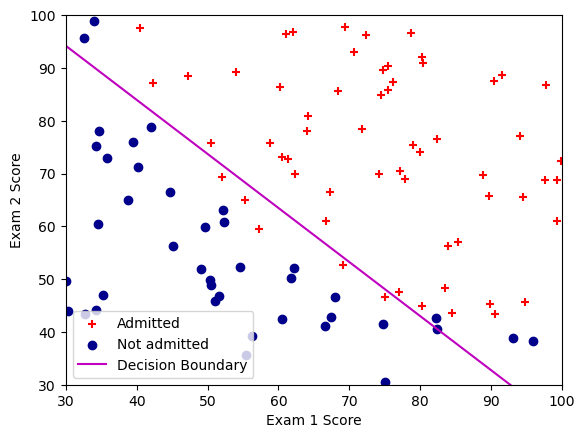

For a student with scores 45 and 85, we predict an admission probability of:  0.7763036859672799
Train Accuracy:  89.0


In [123]:
def logistic_regression():
    """针对第一组数据建立逻辑回归模型。"""

    # 加载数据
    data = np.loadtxt("LR_data1.txt", delimiter=",")
    X, y = data[:, :2], data[:, 2]

    # 计算代价与梯度
    m, _ = X.shape
    X = np.hstack((np.ones((m, 1)), X))

    # 初始化参数
    theta_initial = np.zeros_like(X[0])
    print(theta_initial.shape)
    print(X.shape)
    # 计算并打印初始参数对应的代价与梯度
    cost = cost_function(theta_initial, X, y)
    grad = cost_gradient(theta_initial, X, y)
    print("Cost at initial theta (zeros): ", cost)
    print("Gradient at initial theta (zeros): \n", grad)

    # ====================== YOUR CODE HERE ======================
    ret = op.fmin_cg(cost_function,
                 theta_initial,
                 fprime=cost_gradient,
                 args=(X, y),
                 maxiter=400,
                 full_output=True)
    theta_opt, cost_min, _, _, _ = ret
    # ============================================================
    theta_opt, cost_min, _, _, _ = ret
    print("Cost at theta found by fmin_cg: ", cost_min)
    print("theta_op: \n", theta_opt)

    # 绘制分类面
    plot_decision_boundary(theta_opt, X, y)
    plt.show()


    # 预测考试一得45分，考试二得85分的学生的录取概率
    x_test = np.array([1, 45, 85.0])
    prob = sigmoid(np.dot(theta_opt, x_test))
    print('For a student with scores 45 and 85, we predict an admission probability of: ', prob)

    # 计算在训练集上的分类正确率
    p = predict(theta_opt, X)
    print("Train Accuracy: ", np.mean(p == y)*100.)
    
logistic_regression()

# 正则化的逻辑回归
## 数据可视化
调用函数`plot_data`可视化第二组数据 `LR_data2.txt` 。
正确的输出如下：

![LR_data2](LR_data2_visual.png)

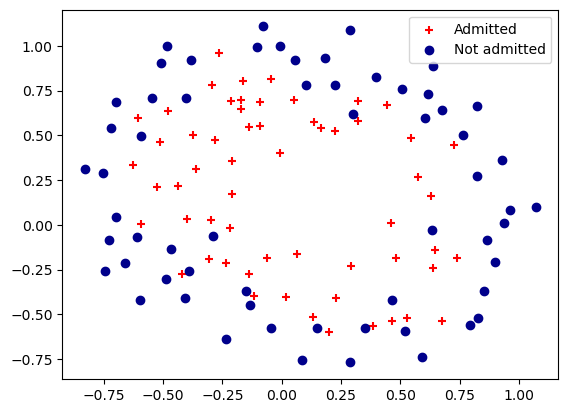

In [133]:
# 加载数据
data = np.loadtxt("LR_data2.txt", delimiter=",")
X, y = data[:, :2], data[:, 2]

# 可视化数据
# ====================== YOUR CODE HERE ================
plt.figure()
admitted_index = []
for i in range(y.size):
    if y[i] == 1:
        admitted_index.append(i)

not_admitted_index = [i for i in range(y.size) if i not in admitted_index]

plt.scatter(X[admitted_index, 0], X[admitted_index, 1], color='red', marker='+', label='Admitted')
plt.scatter(X[not_admitted_index, 0], X[not_admitted_index, 1], color='darkblue', marker='o', label='Not admitted')
plt.legend()
# ======================================================
plt.show()

## 特征变换
创建更多的特征是充分挖掘数据中的信息的一种有效手段。在函数 map_feature 中，我们将数据映射为其六阶多项式的所有项。

$$ \text{map\_feature}(\mathbf{x}) = \begin{bmatrix} 1\\ x_1\\ x_2 \\ x_1^2 \\ x_1 x_2 \\x_2^2 \\ x_1^3 \\ \vdots \\ x_1 x_2^5 \\ x_2^6 \end{bmatrix} $$


In [134]:
def map_feature(X1, X2, degree=6):
    """Feature mapping function to polynomial features."""
    m = len(X1)
    assert len(X1) == len(X2)
    n = int((degree+2)*(degree+1)/2)

    out = np.zeros((m, n))

    idx = 0
    for i in range(degree+1):
        for j in range(i+1):
            # print i-j, j, idx
            out[:, idx] = np.power(X1, i-j)*np.power(X2, j)
            idx += 1

    return out

## 代价函数与梯度
逻辑回归的代价函数为

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left [ -y^{(i)} \log \left (h_{\theta}(x^{(i)}) \right) - (1-y^{(i)}) \log \left (
1- h_{\theta}(x^{(i)}) \right ) \right ] + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_{j}^{2}$$

对应的梯度向量各分量为：

\begin{split}
\frac{\partial J(\theta)}{\partial \theta_{0}} &= \frac{1}{m} \sum_{i=1}^{m} \big( h_{\theta}(x^{(i)}) - y^{(i)} \big) x_{0}^{(i)} \qquad \qquad \text{for } j=0 \\
\frac{\partial J(\theta)}{\partial \theta_{j}} &= \frac{1}{m} \sum_{i=1}^{m} \big( h_{\theta}(x^{(i)}) - y^{(i)} \big) x_{j}^{(i)} + \frac{\lambda}{m} \theta_{j} \qquad \text{for } j \geq 1
\end{split}

完成以下函数：
- `cost_function_reg()`
- `cost_gradient_reg()`

In [140]:
def cost_function_reg(theta, X, y, lmb):
    """逻辑回归的代价函数，有正则项。"""
    m = 1.0*len(y)
    J = 0
    # ====================== YOUR CODE HERE ======================
    h = sigmoid(np.matmul(X, theta))
    epsilon = 1e-10
    h = np.clip(h, epsilon, 1 - epsilon)    # h in [epsilon, 1-epsilon]

    cost = (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    reg = lmb / (2 * m) * np.sum(theta*theta)
    J = cost + reg
    # ============================================================

    return J


def cost_gradient_reg(theta, X, y, lmb):
    """逻辑回归的代价函数的梯度，有正则项。"""

    m = 1.0*len(y)
    grad = np.zeros_like(theta)
    # ====================== YOUR CODE HERE ======================
    h = sigmoid(np.matmul(X, theta))
    grad = np.zeros_like(theta)
    
    # 计算基础梯度（所有theta分量）
    g = h - y
    grad = (np.matmul(X.T, g)) / m
    grad[1:] += (lmb / m) * theta[1:]
    # ============================================================

    return grad

## 模型训练
如果将参数$\theta$ 初始化为全零值，相应的代价函数约为 0.693。可以使用与前述无正则化项类似的方法实现梯度下降，
获得优化后的参数 $\theta^{*}$ 。
你可以调用 plot_decision_boundary 函数来查看最终得到的分类面。建议你调整正则化项的系数，分析正则化对分类面的影响!

参考输出图像：

![](LR_data2_boundary.png)

(118, 28)
Cost at initial theta (zeros):  0.6931471805599454
Gradient at initial theta (zeros): 
 [8.47457627e-03 1.87880932e-02 7.77711864e-05 5.03446395e-02
 1.15013308e-02 3.76648474e-02 1.83559872e-02 7.32393391e-03
 8.19244468e-03 2.34764889e-02 3.93486234e-02 2.23923907e-03
 1.28600503e-02 3.09593720e-03 3.93028171e-02 1.99707467e-02
 4.32983232e-03 3.38643902e-03 5.83822078e-03 4.47629067e-03
 3.10079849e-02 3.10312442e-02 1.09740238e-03 6.31570797e-03
 4.08503006e-04 7.26504316e-03 1.37646175e-03 3.87936363e-02]
         Current function value: 0.535776
         Iterations: 8
         Function evaluations: 68
         Gradient evaluations: 58
Cost at theta found by fmin_cg:  0.5357757195186119
theta_op: 
 [ 1.22008591  0.6174169   1.18134764 -1.96102914 -0.84518957 -1.23644428
  0.09323171 -0.35130743 -0.35278837 -0.19758548 -1.46793288 -0.09276645
 -0.57816353 -0.25825218 -1.18239765 -0.27467132 -0.21615072 -0.06863601
 -0.25974267 -0.28202028 -0.56424266 -1.07964814 -0.009002

/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1659: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,
/var/folders/07/rkr2bxzj5239ldvcztbkd7xm0000gn/T/ipykernel_4922/3756444921.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i, j] = np.dot(map_feature(uu, vv), theta)
/var/folders/07/rkr2bxzj5239ldvcztbkd7xm0000gn/T/ipykernel_4922/3756444921.py:29: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  CS.collections[0].set_label('Decision boundary')


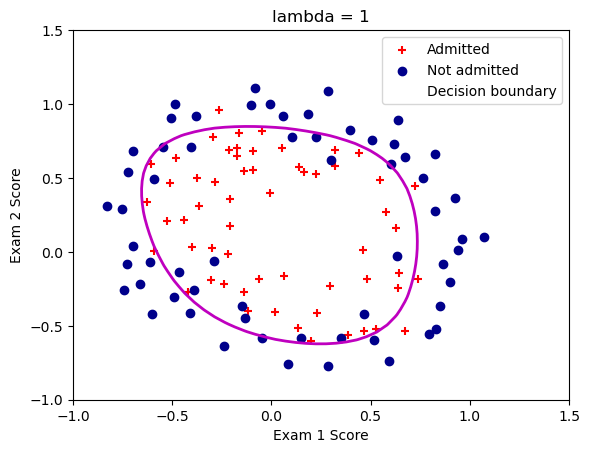

Train Accuracy:  83.05084745762711


In [145]:
def logistic_regression_reg(lmb=1.0):
    """针对第二组数据建立逻辑回归模型。"""

    # 加载数据
    data = np.loadtxt("LR_data2.txt", delimiter=",")
    X, y = data[:, :2], data[:, 2]

    # 计算具有正则项的代价与梯度

    # 注意map_feature会自动加入一列 1
    X = map_feature(X[:, 0], X[:, 1])
    print(X.shape)
    # 初始化参数
    theta_initial = np.zeros_like(X[0, :])

    # 计算并打印初始参数对应的代价与梯度
    cost = cost_function_reg(theta_initial, X, y, lmb=lmb)
    grad = cost_gradient_reg(theta_initial, X, y, lmb=lmb)
    print("Cost at initial theta (zeros): ", cost)
    print("Gradient at initial theta (zeros): \n", grad)

    # 使用 scipy.optimize.fmin_cg 优化模型参数
    args = (X, y, lmb)
    maxiter = 200
    # ====================== YOUR CODE HERE ======================
    ret = op.fmin_cg(
        f=cost_function_reg,
        x0=theta_initial,
        fprime=cost_gradient_reg,
        args=args,
        maxiter=maxiter,
        full_output=True,
        retall=False
    )
    # ============================================================
    theta_opt, cost_min, _, _, _ = ret
    print("Cost at theta found by fmin_cg: ", cost_min)
    print("theta_op: \n", theta_opt)

    # 绘制分类面
    plot_decision_boundary(theta_opt, X, y)
    plt.title("lambda = " + str(lmb))
    plt.show()

    # 计算在训练集上的分类正确率
    pred = predict(theta_opt, X)
    print("Train Accuracy: ", np.mean(pred == y)*100)
# 可选：尝试不同正则化系数lmb = 0.0, 1.0, 10.0, 100.0对分类面的影响
logistic_regression_reg(lmb=1) 